# Bootstrap Aggregation

In this notebook, we'll look at a technique that can be used to improve predictions.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.tree import DecisionTreeRegressor

We'll use the same data generation process as before.

In [2]:
def generateData(size = 50, sigma = 0.2, random_state = None):
    if random_state:
        np.random.seed(random_state)
    
    x1 = np.random.uniform(low = 0, high = 1, size = size)
    x2 = np.random.uniform(low = 0, high = 1, size = size)
    y = np.sin(2*np.pi*x1) + np.cos(2*np.pi*x2) + np.random.normal(loc = 0, scale = sigma, size = size)
    
    X = np.c_[x1, x2]
    
    return X, y

In [3]:
X, y = generateData(size = 50, random_state = 321)
X_eval, y_eval = generateData(size = 10000)

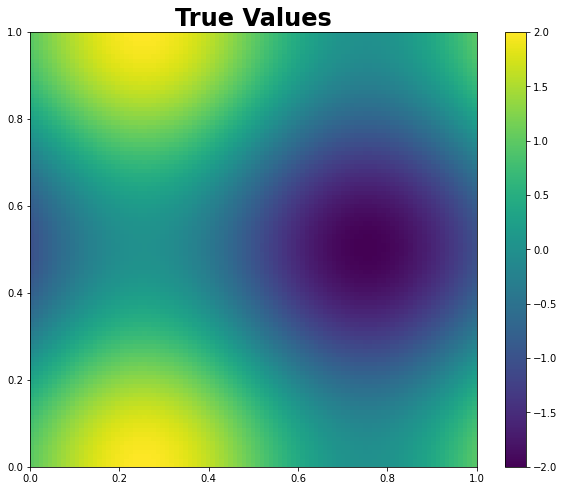

In [4]:
plt.figure(figsize = (10,8))

u = np.linspace(0, 1, 100)
v = np.linspace(0, 1, 100)
U,V = np.meshgrid(u, v)
Z = np.sin(2*np.pi*U) + np.cos(2*np.pi*V)
plt.pcolor(U, V, Z, vmin = -2, vmax = 2)
plt.colorbar()
plt.title('True Values', fontsize = 24, fontweight = 'bold')
cm = plt.get_cmap();

The idea behind **bootstrap aggregation** is to fit a large number of models and then to aggregate (average) their predictions to get the final prediction. 

If we fit on the same dataset each time, we would end up averaging copies of the same model, so to prevent this, we create a bootstrap sample from the original dataset - a sample drawn with replacement from the original dataset of the same size as that datset.

In [6]:
class BaggedTreeRegressor():
    def __init__(self, num_trees = 100):
        self.num_trees = num_trees
    
    def fit(self, X, y):
        trees = []
        for _ in range(self.num_trees):
            # First, draw a bootstrap sample from the data
            idx = np.random.choice(range(len(X)), size = len(X))
            
            X_sub = X[idx]
            y_sub = y[idx]
            
            dt = DecisionTreeRegressor().fit(X_sub, y_sub)
            trees.append(dt)
        self.trees_ = trees
        return self
        
    def predict(self, X):
        predictions = [dt.predict(X) for dt in self.trees_]
        return np.array(predictions).mean(axis = 0)

Let's see how much aggregating improves our model:

In [7]:
from sklearn.metrics import mean_squared_error

In [11]:
dt = DecisionTreeRegressor(random_state = 321).fit(X, y)

In [12]:
mean_squared_error(y, dt.predict(X))

0.0

In [13]:
mean_squared_error(y_eval, dt.predict(X_eval))

0.2640053516656356

Here are the predictions generated using just a single decision tree:

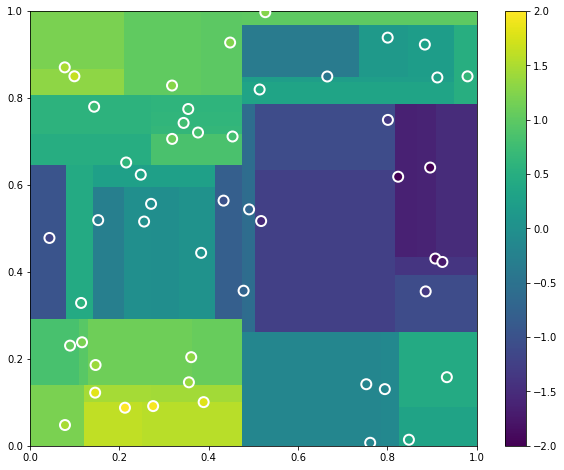

In [14]:
Z = dt.predict(np.array([U.ravel(), V.ravel()]).T)
Z = Z.reshape(U.shape)

fig, ax = plt.subplots(figsize = (10,8))

plt.pcolor(U, V, Z, vmin = -2, vmax = 2)
plt.colorbar()

cm = plt.get_cmap()
plt.scatter(X[:,0], X[:,1], edgecolor = 'white', linewidth = 2,
            s = 100, c = y, cmap = cm, zorder = 100);

In [15]:
bt = BaggedTreeRegressor(num_trees = 100)

In [16]:
bt.fit(X, y)

In [17]:
mean_squared_error(y, bt.predict(X))

0.025617038982698685

In [18]:
mean_squared_error(y_eval, bt.predict(X_eval))

0.179042508991347

If we look at the predictions generated, we see that we get a smoother overall appearance.

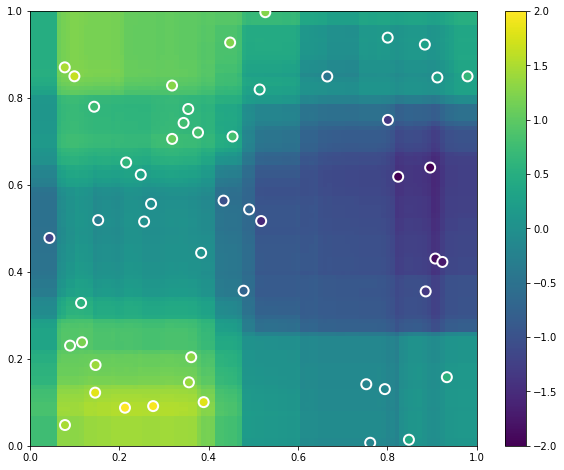

In [20]:
Z = bt.predict(np.array([U.ravel(), V.ravel()]).T)
Z = Z.reshape(U.shape)

fig, ax = plt.subplots(figsize = (10,8))

plt.pcolor(U, V, Z, vmin = -2, vmax = 2)
plt.colorbar()

cm = plt.get_cmap()
plt.scatter(X[:,0], X[:,1], edgecolor = 'white', linewidth = 2,
            s = 100, c = y, cmap = cm, zorder = 100);

**Question:** Will this also work with linear regression models?

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
linreg = LinearRegression().fit(X, y)

In [23]:
mean_squared_error(y_eval, linreg.predict(X_eval))

0.7729007444910091

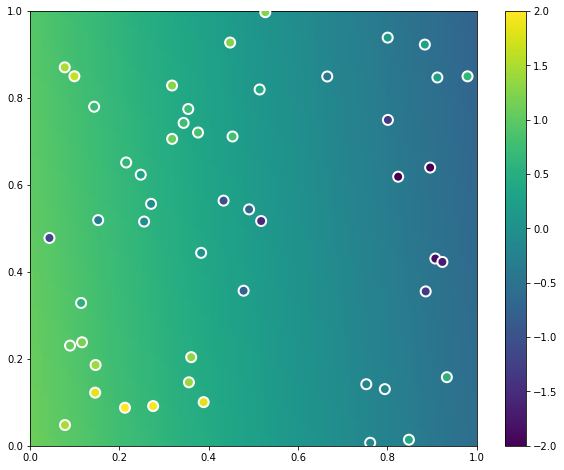

In [24]:
Z = linreg.predict(np.array([U.ravel(), V.ravel()]).T)
Z = Z.reshape(U.shape)

fig, ax = plt.subplots(figsize = (10,8))

plt.pcolor(U, V, Z, vmin = -2, vmax = 2)
plt.colorbar()

cm = plt.get_cmap()
plt.scatter(X[:,0], X[:,1], edgecolor = 'white', linewidth = 2,
            s = 100, c = y, cmap = cm, zorder = 100);

In [25]:
class BaggedLinRegressor():
    def __init__(self, num_trees = 100):
        self.num_trees = num_trees
    
    def fit(self, X, y):
        linreg = []
        for _ in range(self.num_trees):
            idx = np.random.choice(range(len(X)), size = len(X))
            
            X_sub = X[idx]
            y_sub = y[idx]
            
            dt = LinearRegression().fit(X_sub, y_sub)
            linreg.append(dt)
        self.models_ = linreg
        
    def predict(self, X):
        predictions = [model.predict(X) for model in self.models_]
        return np.array(predictions).mean(axis = 0)

In [26]:
br = BaggedLinRegressor(num_trees = 1000)

In [27]:
br.fit(X, y)

In [28]:
mean_squared_error(y_eval, br.predict(X_eval))

0.7690537534582317

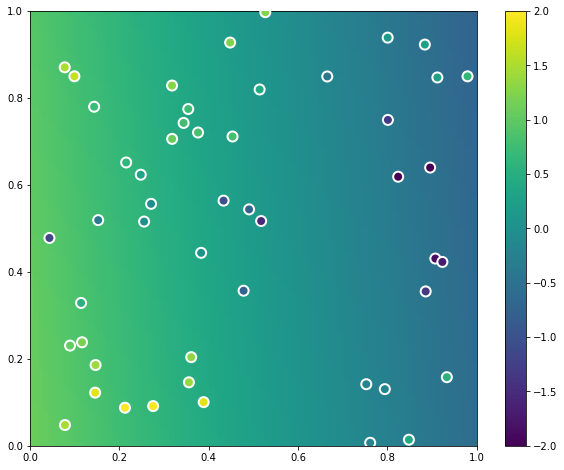

In [29]:
Z = br.predict(np.array([U.ravel(), V.ravel()]).T)
Z = Z.reshape(U.shape)

fig, ax = plt.subplots(figsize = (10,8))

plt.pcolor(U, V, Z, vmin = -2, vmax = 2)
plt.colorbar()

cm = plt.get_cmap()
plt.scatter(X[:,0], X[:,1], edgecolor = 'white', linewidth = 2,
            s = 100, c = y, cmap = cm, zorder = 100);

**Question:** Why did we not see a significant improvement in performance with the linear regression models compared to the decision tree models?

## Bagged Decision Trees on the King County Housing Dataset

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [32]:
kc = pd.read_csv('../data/kc_house_data.csv')

X = kc[['date', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']]
y = kc['price']

X['date'] = pd.to_datetime(X['date'])
X['sales_year'] = X['date'].dt.year
X['sales_month'] = X['date'].dt.month

X['age_at_sale'] = X['sales_year'] - X['yr_built']
X['years_since_renovation'] = X['sales_year'] - np.max(X[['yr_built', 'yr_renovated']], axis = 1)

X = X.drop(columns = ['date', 'yr_built', 'yr_renovated'])

X = pd.get_dummies(X, columns = ['zipcode', 'sales_year', 'sales_month'], drop_first = True)

<ipython-input-32-ec3a98b8ae1c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['date'] = pd.to_datetime(X['date'])
<ipython-input-32-ec3a98b8ae1c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sales_year'] = X['date'].dt.year


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321)

Because of the way we wrote the BaggedTreeRegressor, we'll need to pass in X and y as numpy arrays.

In [36]:
bt = BaggedTreeRegressor().fit(X_train.values, y_train.values)

In [37]:
y_pred = bt.predict(X_test.values)

In [38]:
mean_squared_error(y_test, y_pred)

15581827472.724325

In [39]:
mean_absolute_error(y_test, y_pred)

66368.96799133359

In [40]:
bt = BaggedTreeRegressor().fit(X_train.values, np.log(y_train.values))

In [41]:
y_pred = np.exp(bt.predict(X_test.values))

In [42]:
mean_squared_error(y_test, y_pred)

19393768779.205544

In [43]:
mean_absolute_error(y_test, y_pred)

68491.91365711753

**Pros:** The best mean absolute error that we've seen so far.

**Cons:** Very slow.